In [1]:
%load_ext autoreload
%autoreload 2
import glob
import matplotlib.pyplot as plt
from matplotlib import cycler
import datetime
import pandas as pd
import os
import helper
import numpy as np
import seaborn as sns
import itertools
import json



In [2]:
hotfile = "dataset/data15/15/satellite/1.1Mbps/1/HAR/run_1_vid_1_6841591262680730886.har"

In [3]:


cycler_colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#CF4457', '#188487', '#E24A33']
def set_matplot_params(font_size = 8, xtick_major = 0.25, xtick_minor = 0.25, ytick_major = 0.25, ytick_minor = 0.25):
    params_dict = {
        'text.usetex': False,
        # 'font.family': 'Times New Roman',
        # 'font.serif': 'Times New Roman',
        # 'font.sans-serif': 'Times New Roman',
        'font.size': font_size,
        'figure.figsize': [3.125, 1.93],  # Golden ratio
        #figure.figsize: 3.125, 1.56  # Squash for more space
        'legend.fontsize': 6,
        'legend.fancybox': False,
        'axes.linewidth': 0.5,
        'pdf.fonttype' : 42,
        'ps.fonttype' : 42,
        'axes.prop_cycle': cycler("color", cycler_colors),
                          # 348ABD : blue
                          # A60628 : red
                          # 7A68A6 : purple
                          # 467821 : green
                          # CF4457 : pink
                          # 188487 : turquoise
                          # E24A33 : orange
        'patch.linewidth': 0.5,
        'lines.linewidth': 2,
        'grid.linewidth': 0.1,
        'xtick.major.width': xtick_major,
        'xtick.minor.width': xtick_minor,
        'ytick.major.width': ytick_major,
        'ytick.minor.width': ytick_minor,
        'legend.numpoints': 1}
    plt.rcParams.update(params_dict)
set_matplot_params()

In [4]:
# Initialize an empty list to store per chunk data
per_chunk_data = []

# function to parese an har file and convert it to a csv file filtered only for video chunks
def parse_har_to_csv(har_file_path, csv_file_path):
    # Read the HAR file
    with open(har_file_path, 'r') as har_file:
        har_data = json.load(har_file)
    
    # Extract the video chunks
    # Filtering criteria for video chunks:
        # 1. The request URL ends with .ts
        # 2. The response status is 200

    video_chunks = []
    # Get the greate grandparent folder name
    rate_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(har_file_path))))
    network_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(har_file_path)))))
    time_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(har_file_path))))))

    for entry in har_data['log']['entries']:
        request_url = entry['request']['url']
        response_status = entry['response']['status']
        if request_url.endswith('.js') and response_status == 200:
            chunk_size = entry['response']['bodySize'] * 8 / 1024 / 1024
            chunk_start_time = datetime.datetime.fromisoformat(entry['startedDateTime'])
            chunk_duration = datetime.timedelta(seconds=entry['time']* 0.001) 
            chunk_end_time = (chunk_start_time + chunk_duration).isoformat()
            timings = str(entry['timings'])
            video_chunks.append({
                'start_time': chunk_start_time,
                'end_time': chunk_end_time,
                'size': chunk_size,
                'url': request_url,
                'timings': timings
            })
            
            per_chunk_data.append({
                'network': network_folder,
                'rate': rate_folder,
                'time': time_folder,
                'start_time': chunk_start_time,
                'end_time': chunk_end_time,
                'total_time': chunk_duration.total_seconds(),
                'size': chunk_size,
                'url': request_url,
                'timings': timings
            })

            df = pd.DataFrame(video_chunks)
            
            df.to_csv(csv_file_path, index=False)
parse_har_to_csv(hotfile, "temp.csv")


In [5]:
# given a the csv file created above, write a function to calculate the metrics:
    # Chunk size: Avg, mean, std, median, min, max
    # Number of chunks
    # idle time between chunks (mean, std, median, min, max)
    # video throughput

def calculate_metrics(csv_file_path, file_path=None):

    # if file is empty, or only containes blank spaces, print the file path and return
    
    
    # Read the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Calculate the chunk size metrics
    chunk_sizes = df['size']
    avg_chunk_size = chunk_sizes.mean()
    mean_chunk_size = chunk_sizes.mean()
    std_chunk_size = chunk_sizes.std()
    median_chunk_size = chunk_sizes.median()
    min_chunk_size = chunk_sizes.min()
    max_chunk_size = chunk_sizes.max()
    
    # Calculate the number of chunks
    num_chunks = len(df)
    
    # Calculate the idle time between chunks
    # get the start times starting from the second chunk
    start_times = pd.to_datetime(df['start_time'], format='ISO8601')[1:]
    end_times = pd.to_datetime(df['end_time'], format='ISO8601')[:-1]

    # calculate the idle time between chunks
    idle_times = end_times - start_times

    idle_times.dropna()

    idle_times = idle_times.dt.total_seconds()


    avg_idle_time = idle_times.mean()
    std_idle_time = idle_times.std()
    median_idle_time = idle_times.median()
    min_idle_time = idle_times.min()
    max_idle_time = idle_times.max()
    
    # Calculate the video throughput
    total_video_size = chunk_sizes.sum()
    video_duration = end_times.max() - start_times.min()
    video_goodput = total_video_size / video_duration.total_seconds()

    if video_goodput <= 0:
        video_goodput = 0
        print(file_path)
    

    # Return the metrics
    return {
        'avg_chunk_size': avg_chunk_size,
        'mean_chunk_size': mean_chunk_size,
        'std_chunk_size': std_chunk_size,
        'median_chunk_size': median_chunk_size,
        'min_chunk_size': min_chunk_size,
        'max_chunk_size': max_chunk_size,
        'num_chunks': num_chunks,
        'avg_idle_time': avg_idle_time,
        'std_idle_time': std_idle_time,
        'median_idle_time': median_idle_time,
        'min_idle_time': min_idle_time,
        'max_idle_time': max_idle_time,
        'video_goodput': video_goodput
    }

In [6]:
calculate_metrics("temp.csv")

{'avg_chunk_size': 0.3569547591670867,
 'mean_chunk_size': 0.3569547591670867,
 'std_chunk_size': 0.9972873572810184,
 'median_chunk_size': 0.0290679931640625,
 'min_chunk_size': 0.0015182495117187,
 'max_chunk_size': 6.7822265625,
 'num_chunks': 93,
 'avg_idle_time': 2.769164835164835,
 'std_idle_time': 5.43932673583727,
 'median_idle_time': 0.98,
 'min_idle_time': 0.578,
 'max_idle_time': 32.007,
 'video_goodput': 0.6036878087386627}

In [7]:
def loop_through_har_files(root_dir):
    data = []
    
    # Loop through the subfolders of the root directory
    for time in os.listdir(root_dir):
        time_dir = os.path.join(root_dir, time)

        for network in os.listdir(time_dir):
            network_folder_path = os.path.join(time_dir, network)
            
            # Check if the subfolder is a directory
            if os.path.isdir(network_folder_path):
                
                # Loop through the shaping rate folders
                for shaping_rate_folder in os.listdir(network_folder_path):
                    shaping_rate_folder_path = os.path.join(network_folder_path, shaping_rate_folder)
                    
                    # Check if the subfolder is a directory
                    if os.path.isdir(shaping_rate_folder_path):
                        for experiment in os.listdir(shaping_rate_folder_path):
                            experiment_folder_path = os.path.join(shaping_rate_folder_path, experiment)

                            if os.path.isdir(experiment_folder_path):
                                har_path = os.path.join(experiment_folder_path, "HAR")
                                for file in os.listdir(har_path):
                                    file_path = os.path.join(har_path, file)
                                  
                            
                                    # # Check if the file is a HAR file
                                    if file_path.endswith('.har'):

                                        # Extract the shaping rate and grandparent folder names
                                        shaping_rate = shaping_rate_folder
                                        
                                        parse_har_to_csv(file_path, "temp.csv")
                                        metrics = calculate_metrics("temp.csv", file_path)
                                        
                                        # Append the data to the list
                                        row = [network, shaping_rate, time, experiment]
                                        row.extend(metrics.values())
                                        data.append(row)
        

    
    columns = ['network', 'rate', 'time', 'experiment_number']
    columns.extend(metrics.keys())
    df = pd.DataFrame(data, columns=columns)
    
    return df


In [8]:
main_df_15 = loop_through_har_files('dataset/data15')
main_df_60 = loop_through_har_files('dataset/data60')

main_df_15.to_csv('main_df_15.csv', index=False)
main_df_60.to_csv('main_df_60.csv', index=False)

# print the keys of main_df
print(main_df_15.keys())

print(main_df_60.head(10))

Index(['network', 'rate', 'time', 'experiment_number', 'avg_chunk_size',
       'mean_chunk_size', 'std_chunk_size', 'median_chunk_size',
       'min_chunk_size', 'max_chunk_size', 'num_chunks', 'avg_idle_time',
       'std_idle_time', 'median_idle_time', 'min_idle_time', 'max_idle_time',
       'video_goodput'],
      dtype='object')
     network   rate time experiment_number  avg_chunk_size  mean_chunk_size  \
0  satellite  5Mbps   60                 3        0.341189         0.341189   
1  satellite  5Mbps   60                 3        0.341185         0.341185   
2  satellite  5Mbps   60                 3        0.341182         0.341182   
3  satellite  5Mbps   60                 3        0.344759         0.344759   
4  satellite  5Mbps   60                 3        0.341185         0.341185   
5  satellite  5Mbps   60                 3        0.341155         0.341155   
6  satellite  5Mbps   60                 3        0.344752         0.344752   
7  satellite  5Mbps   60       

In [13]:
per_chunk_df = pd.DataFrame(per_chunk_data)

combo: ('5Mbps',), Mean: 0.03232234274457116, Median: 0.0290679931640625
combo: ('3Mbps',), Mean: 0.03585520640269174, Median: 0.0290679931640625
combo: ('1.1Mbps',), Mean: 0.038235261072566834, Median: 0.0348892211914062


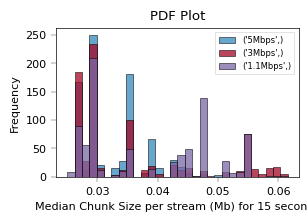

combo: ('5Mbps',), Mean: 0.03212825647381504, Median: 0.0348663330078125
combo: ('3Mbps',), Mean: 0.03629171876748021, Median: 0.0348892211914062
combo: ('1.1Mbps',), Mean: 0.03980280940694019, Median: 0.0348892211914062


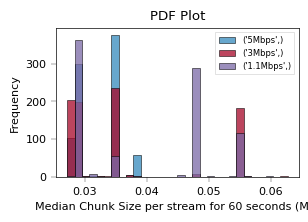

In [14]:
helper.plot_multiple_cdfs(
    df=main_df_15,
    keys=['rate'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream (Mb) for 15 seconds',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

helper.plot_multiple_cdfs(
    df=main_df_60,
    keys=['rate'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream for 60 seconds (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('satellite',), Mean: 1.0854866795755345, Median: 1.1837346509669324
combo: ('campus',), Mean: 1.515773963121644, Median: 1.559440353561317


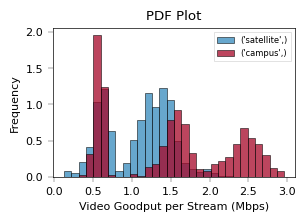

combo: ('satellite',), Mean: 1.0263043942171286, Median: 1.1448363857471433
combo: ('campus',), Mean: 1.4464162928839621, Median: 1.4769914628742544


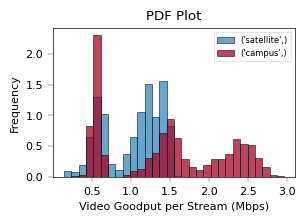

In [16]:
# plotting the throughput of streams
helper.plot_multiple_cdfs(
    df=main_df_15,
    keys=['network'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)
helper.plot_multiple_cdfs(
    df=main_df_60,
    keys=['network'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('satellite',), Mean: 0.3493077079980684, Median: 0.04236602783203125
combo: ('campus',), Mean: 0.3029068992407089, Median: 0.032379150390625


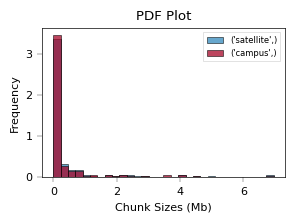

combo: ('satellite',), Mean: 0.3493077079980684, Median: 0.04236602783203125
combo: ('campus',), Mean: 0.3029068992407089, Median: 0.032379150390625


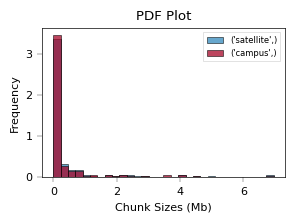

In [17]:
helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['network'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('15',), Mean: 0.3266631433028524, Median: 0.0325469970703125
combo: ('60',), Mean: 0.3254322272327643, Median: 0.03481292724609375


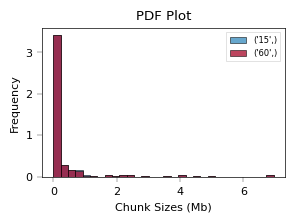

In [18]:
helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['time'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('15',), Mean: 1.3007736548874123, Median: 1.307310064410356


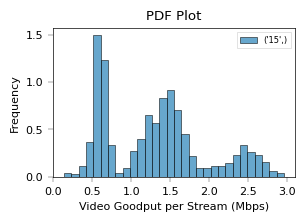

combo: ('60',), Mean: 1.2304121572830131, Median: 1.229575072000246


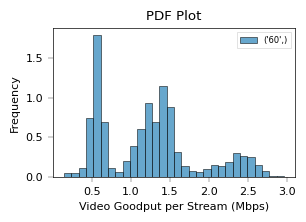

In [21]:
# plot video throughput by category
helper.plot_multiple_cdfs(
    df=main_df_15,
    keys=['time'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

helper.plot_multiple_cdfs(
    df=main_df_60,
    keys=['time'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('satellite',), Mean: 0.03625897216796872, Median: 0.03077316284179685
combo: ('campus',), Mean: 0.04019198276028774, Median: 0.0348892211914062


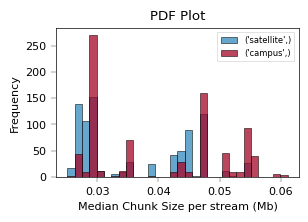

combo: ('satellite',), Mean: 0.040258989334106425, Median: 0.0478706359863281
combo: ('campus',), Mean: 0.03934433711833091, Median: 0.0348892211914062


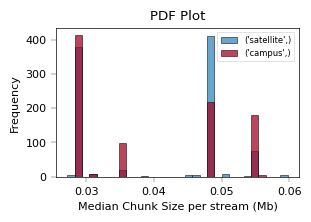

In [22]:

helper.plot_multiple_cdfs(
    df=main_df_15,
    keys=['network'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)


helper.plot_multiple_cdfs(
    df=main_df_60,
    keys=['network'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)